## Setup notebook

In [0]:
%pip install geopy > /dev/null 2>&1
dbutils.library.restartPython()

In [0]:
# Core
import requests
import re
import logging
import warnings

# Data handling
import pandas as pd
import numpy as np
import math

# API management
import backoff
from geopy.exc import GeocoderTimedOut

In [0]:
# Load in locations planning to geolocate
df = pd.read_csv('/no_duplicates.csv')
df.head(10)

,location
0,London
1,"London, GB, W1A 1AA"
2,"LUTON AIRPORT, UK"
3,"SOUTHAMPTON INTL AIRPORT, UK"
4,"NORTHOLT, UK"
5,United Kingdom
6,"116/118 Market Street St Andrews, United Kingdom"
7,Crawley
8,Reading
9,Cheadle


## Preparing for geolocation
- Setting up logging to handle errors gracefully
- Preparing to store aside locations that failed to be geolocated
- Specifying list of address elements we expect from each API response

In [0]:
# Setting up dataframes for later
final_df = pd.DataFrame()
batched_dfs = pd.DataFrame()

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger("py4j.clientserver").setLevel(logging.ERROR)

# Define the LocationIQ access token
LOCATIONIQ_ACCESS_TOKEN = "pk.a6a753d4f351d2d1796e949e2d97429e"

# Define list of address elements
address_elements = [
    "name",
    "house_number",
    "road",
    "neighbourhood",
    "suburb",
    "island",
    "city",
    "county",
    "state",
    "state_code",
    "postcode",
    "country",
    "country_code",
]

## Defining the geolocation function 'geocode_location'
- Using exponential backoff to manage API throttling
- Setting the base URL for the LocationIQ API, including parameters
- Makes the HTTP GET request to API, using requests.get to retrieve data

In [0]:
# Exponential backoff to circumvent API timeouts to LocationIQ
@backoff.on_exception(
    backoff.expo, (GeocoderTimedOut, requests.exceptions.RequestException), max_tries=10
)
@backoff.on_predicate(
    backoff.expo,
    lambda x: "Invalid Request: Rate Limited" in x["LocationIQ_address"],
    max_tries=10,
)

# Function definition
def geocode_location(x, countrycodes=None):
    base_url = "https://eu1.locationiq.com/v1/search"
    if countrycodes:
        params = {
            "key": LOCATIONIQ_ACCESS_TOKEN,
            "q": x,
            "format": "json",
            "addressdetails": 1,
            "normalizeaddress": 1,
            "countrycodes": countrycodes,
            "statecode": 0,
            "matchquality": 1,
        }
    else:
        params = {
            "key": LOCATIONIQ_ACCESS_TOKEN,
            "q": x,
            "format": "json",
            "addressdetails": 1,
            "normalizeaddress": 1,
            "statecode": 0,
            "matchquality": 1,
        }

    # Make the API request
    response = requests.get(base_url, params=params)
    data = response.json()

    # Initialize address dictionary
    x_address = {}

    if "error" in data:
        # Handle error case
        x_address["LocationIQ_address"] = "Invalid Request: " + data["error"]
        x_address["latitude"] = "No latitude"
        x_address["longitude"] = "No longitude"
        x_address["matchcode"] = "No matchcode"
        x_address["matchtype"] = "No matchtype"
        x_address["LocationIQ_potential_locations"] = "No matches"
        for element in address_elements:
            x_address[element] = "No address element"

    elif data and len(data) > 0:
        x_address["latitude"] = data[0].get("lat", "No latitude")
        x_address["longitude"] = data[0].get("lon", "No longitude")
        matchquality = data[0].get("matchquality", {})
        x_address["matchcode"] = matchquality.get("matchcode", "No matchcode")
        x_address["matchtype"] = matchquality.get("matchtype", "No matchtype")
        x_address["LocationIQ_address"] = data[0].get("display_name", "No display name")
        x_address["LocationIQ_potential_locations"] = len(data)
        address_details = data[0].get("address", {})
        for element in address_elements:
            x_address[element] = address_details.get(element, "No address element")
    else:
        x_address["LocationIQ_address"] = "LocationIQ cannot find address"
        x_address["latitude"] = "No latitude"
        x_address["longitude"] = "No longitude"
        x_address["matchcode"] = "No matchcode"
        x_address["matchtype"] = "No matchtype"
        x_address["LocationIQ_potential_locations"] = "No matches"
        for element in address_elements:
            x_address[element] = "No address element"

    return x_address

## Running geocode_location
We're splitting up the processing into batches for better logging and error handling in case of failure


In [0]:
def batch_geocode(df, countrycodes, batch_size):
    """
    Batch geocodes the 'location' column of a DataFrame using the geocode_location function.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing a 'location' column.
        countrycodes (str): Country code(s) to use in the geocode_location function.
        batch_size (int): Number of rows to process per batch.
        
    Returns:
        pd.DataFrame: A DataFrame with geocoded information and a 'match accuracy' column.
    """

    batched_list = []
    total_rows = df.shape[0]
    num_batches = math.ceil(total_rows / batch_size)

    # Loop over batches
    try:
        for i in range(num_batches):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, total_rows)
            print(f"Processing batch {i+1}/{num_batches} ...")

            df_hold = df.iloc[start_index:end_index].copy()

            # Geocoding using geocode_location
            df_hold["geocoded_address"] = df_hold["location"].apply(
                lambda loc: geocode_location(loc, countrycodes=countrycodes)
            )

            df_hold["geocoding_function"] = "within countrycodes"

            # Identify failed geocoding cases
            failed_mask = df_hold["geocoded_address"].apply(
                lambda x: isinstance (x, dict) and "Invalid Request" in x.get("LocationIQ_address", "")                                                               
            )
            if failed_mask.any():
                # Retry these without the countrycodes parameter
                df_hold.loc[failed_mask, "geocoded_address"] = df_hold.loc[failed_mask, "location"].apply(geocode_location)
                df_hold.loc[failed_mask, "geocoding_function"] = "outside of countrycodes country"

            # Extract fields from geocoded_address dictionary
            df_hold["latitude, longitude"] = df_hold["geocoded_address"].apply(
                lambda x: f"{x.get('latitude', 'N/A')}, {x.get('longitude', 'N/A')}"
            )
            df_hold["matchcode"] = df_hold["geocoded_address"].apply(lambda x: x.get("matchcode", "N/A"))
            df_hold["matchtype"] = df_hold["geocoded_address"].apply(lambda x: x.get("matchtype", "N/A"))
            df_hold["LocationIQ_potential_locations"] = df_hold["geocoded_address"].apply(
                lambda x: x.get("LocationIQ_potential_locations", "N/A")
            )
            df_hold["LocationIQ_potential_locations"] = df_hold["LocationIQ_potential_locations"].replace(10, "10 or more")

            # Populate additional address elements
            for element in address_elements:
                df_hold[element] = df_hold["geocoded_address"].apply(lambda x: x.get(element, "N/A"))

            batched_list.append(df_hold)
        
    except KeyboardInterrupt:
        print("Processing interrupted by user. Compiling results so far...")
    except Exception as e:
        print(f"An unexpected error occurred in batch processing: {e}")

    # Concatenate all successfully processed batches
    if batched_list:
        final_df = pd.concat(batched_list, ignore_index=True)
    else:
        final_df = pd.DataFrame()
    
    # Add a 'match accuracy' column
    final_df["match accuracy"] = np.where(
        final_df["matchcode"].isin(["exact", "fallback"]),
        "high accuracy",
        np.where(final_df["matchcode"] == "approximate", "low accuracy", "No match accuracy")
    )

    return final_df

In [0]:
final_df = batch_geocode(df, "gb", 100)

Processing batch 1/10 ...
Processing batch 2/10 ...
Processing batch 3/10 ...
Processing batch 4/10 ...
Processing batch 5/10 ...
Processing batch 6/10 ...
Processing batch 7/10 ...
Processing batch 8/10 ...
Processing batch 9/10 ...
Processing batch 10/10 ...


## Geolocation Evaluation Success
Lets have a look at how many unique locations we could not geolocate (because the location is too 'dirty')

In [0]:
total_rows = final_df.shape[0]
geolocated_count = (final_df["country_code"] != "No address element").sum()
pct_geolocated = (geolocated_count / total_rows) * 100
print(f"Percentage of locations that could be geolocated: {pct_geolocated:.2f}%")

Percentage of locations that could be geolocated: 92.70%


## Geolocation Evaluation Success
What about the popularity of address elements in the UK?

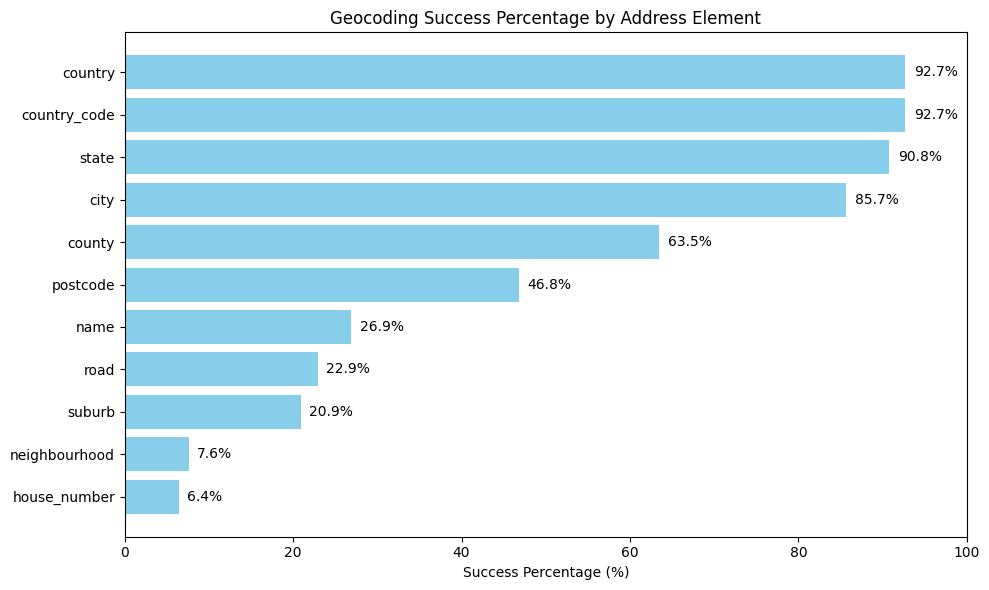

In [0]:
import matplotlib.pyplot as plt

# Compute success percentages for each address element
success_data = {}
for element in address_elements:
    success_count = (final_df[element] != "No address element").sum()
    success_percentage = (success_count / total_rows) * 100
    success_data[element] = success_percentage

# Convert the dictionary to a Series and sort descending (highest success % at top)
success_series = pd.Series(success_data).sort_values(ascending=False)

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(success_series.index, success_series.values, color='skyblue')
plt.xlabel("Success Percentage (%)")
plt.title("Geocoding Success Percentage by Address Element")
plt.xlim(0, 100)  # Since it's a percentage scale
plt.gca().invert_yaxis()  # Highest values on top
# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', va='center')
plt.tight_layout()
plt.show()

## Final insights
With our location data now thoroughly cleaned and structured, we are ready to leverage for further analysis. Specifically, we can::

- **Enrich Job Descriptions:**  
  Update the original job description records by linking them to our table of unique, geocoded locations. This ensures every job posting is associated with a precise, standardized location.

- **Perform Granular Analyses:**  
  Dive deep into location-specific insights by analyzing various address elements—such as state, city, county, and postcode—to uncover regional trends and patterns.